This note book will visualize class activation maps of a pretrained classifier on vegetable and fruits

Class activation maps are very cool simple strategy to pinpoint what areas of an image make a classifier choose its predicted label.  
They are really cool because they can give information about location of the object in the image, <b> even without training a model with bounding boxes or location information! </b>

They were discovered by MIT researchers Bolei Zhou, Aditya Khosla, Agata Lapedriza, Aude Oliva, Antonio Torralba and published in their paper "Learning Deep Features for Discriminative Localization".

# Table of Contents
<ul>
<li>Define Empty Model Architecture, Load Pre trained model</li>
<li>Define data loader, load in a batch of images</li>
<li>Evaluate Pre trained model on batch</li>
<li>Find class activation maps</li>
</ul>

## Model Definition and Loading

Model consists of  
<ol>
    <li>Mobile net backbone whose weights have been frozen</li>
    <li>Dense Matrix Classifier whose weights have been fine tuned on vegetable and fruit classification (recycled from a homework assignment)</li>
</ol>

Load packages

In [88]:
import torch

Load pre trained classifier that classifies type of fruit or vegetable based on image. 

Define empty architecture first before loading.  A quick summary of what it does  
1. takes an input image of size 3 * 224 * 224
2. convolution outputs tensor of shape 1280 * 7 * 7
3. average each 7*7 matrix to get vector of shape 1280
4. vector is multiplied by matrix of size 20 * 1280 to produce a vector shape 20
5. <b>each element in the size 20 vector corresponds to a fruit or vegatable</b>

In [91]:
from torchvision import models
import torch
from torch import nn
class PretrainedClassifier(nn.Module):
  def __init__(self,no_classes):
    super().__init__()
    mobilenet     = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=True)
    self.backbone = mobilenet.features
    for param in self.backbone.parameters():
        param.requires_grad = False #FREEZE
    self.gap = nn.AdaptiveAvgPool2d((1,1))
    self.dense = nn.Linear(1280,no_classes)#62720 is the size of mobilenet backbone output 1280x7x7
  def forward(self,x):
    x=self.backbone(x)
    x=self.gap(x)
    x=torch.flatten(x,1)
    x=self.dense(x)
    return x

Model was trained to distingish 20 different type of fruit or vegetable

In [92]:
#load empty architecture
model = PretrainedClassifier(no_classes=20)
#fill up the weights with pretrained weights
device = 'cpu'
model.load_state_dict(torch.load("mobilenet_classifier_gap.pth", map_location=device))

Using cache found in C:\Users\Walter/.cache\torch\hub\pytorch_vision_v0.10.0


<All keys matched successfully>

## Data Generator

Define a generator that loads batches of shape X: BATCHSIZE * HEIGHT * WIDTH * 3 (RGB) and Y: BATCHSIZE (1 label per item in batch)

In [93]:
from torch.utils.data import Dataset,DataLoader
from torchvision import transforms
from PIL import Image
class VeggieFruitDataset(Dataset):
    def __init__(self,paths,labels):
        self.paths=paths
        self.labels=labels
        #transform copied from https://pytorch.org/hub/pytorch_vision_mobilenet_v2/
        self.transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
    def __len__(self):
        return len(self.paths)
    def __getitem__(self,index):
        image_file = self.paths[index]
        label = self.labels[index]
        image = Image.open(image_file)
        transformed = self.transform(image)  
        return transformed,label

This code block below was provided by the instructor.  It creates dataframe of image paths and corresponding ground truth label

In [94]:
from pathlib import Path
import pandas as pd
data_path = Path("vegitable_fruit")
filepaths = list(data_path.glob(r'**/*.jpg'))
labels = [path.parent.name for path in filepaths]
filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')
# Concatenate filepaths and labels
df = pd.concat([filepaths, labels], axis=1)
#convert the string labels into numbers
class_map = df['Label'].unique().tolist()
df['Label_Index'] = df['Label'].map(lambda label:class_map.index(label))
df.head()

,Filepath,Label,Label_Index
0,vegitable_fruit\vegitable_fruit\Apple\App_021.jpg,Apple,0
1,vegitable_fruit\vegitable_fruit\Apple\App_022.jpg,Apple,0
2,vegitable_fruit\vegitable_fruit\Apple\App_023.jpg,Apple,0
3,vegitable_fruit\vegitable_fruit\Apple\App_024.jpg,Apple,0
4,vegitable_fruit\vegitable_fruit\Apple\App_025.jpg,Apple,0


Load a batch of images

In [115]:
dataset = VeggieFruitDataset(df['Filepath'],df['Label_Index'])
generator = DataLoader(dataset,batch_size=8,shuffle=True)
images,labels = next(iter(generator))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7695861..1.8033988].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7521569..2.4831376].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.5255773..1.5942485].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.457983..2.5877128].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.86326796..2.4831376].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.3687146..1.6465361].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.804444

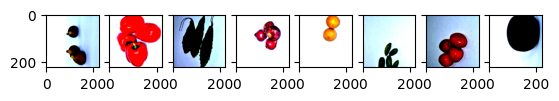

In [116]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(ncols=len(images),sharey=True)
for j in range(len(images)):
  ax[j].imshow(images[j].transpose(0,2))

# Extracting Activation Maps

We must first extract the outputs of final convolutional layer before creation of the representation vector that gets passed to the classification dense layer

Take the first batch and for each image obtain  
1. predicted label
2. output of convolution, the plain old "activation maps" , these are the data right before passing to dense layer

In [117]:
model.eval()
preds = model(images)
preds = preds.argmax(dim=1)
preds

tensor([ 4, 10,  1,  9, 13, 14, 18, 19])

In [118]:
[class_map[pred] for pred in preds]

['Fig',
 'Papper',
 'Bitter_Melon',
 'Onion',
 'Sapodilla',
 'SMG',
 'Tomato_Red',
 'Watermellon']

In [119]:
activation_maps = model.backbone(images)
activation_maps.shape

torch.Size([8, 1280, 7, 7])

Next we get the weights of the dense classifier layer.  This dense layer should be 1280 * number of classes = 20

In [120]:
#only need the weight because that actually multiplies the outputs of convolutional filters
matrix = model.dense.state_dict()['weight']
matrix.shape

torch.Size([20, 1280])

There are 20 rows. Each corresponding to a specific fruit or vegetable. 
1. Take the row corresponding to the model prediction
2. Reshape the row to be the same shape as the number of elements in the global average pooled vector (1280)
3. Multiply each of 1280 weights in the row (step 1) by each of the 1280 7*7 maps
4. Sum the product from step 4. along the channel dimension e.g. go from start shape 1280 * 7 * 7 to end shape 7 * 7

In [121]:
#take row corresponding to model prediction
pred_row = matrix[preds]
#reshape row to be 1280 * 7 * 7
pred_row.shape

torch.Size([8, 1280])

In [122]:
#elementwise-multiply reshaped row by activation maps
multiplied_maps = pred_row[...,None,None] * activation_maps
multiplied_maps.shape

torch.Size([8, 1280, 7, 7])

In [123]:
import torch.nn.functional as F
upsampled_cam = F.upsample(multiplied_maps,size=(224,224),mode='bilinear',align_corners=False)
upsampled_cam.shape

C:\Users\Walter\AppData\Local\Temp\ipykernel_11560\895965336.py:2: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  upsampled_cam = F.upsample(multiplied_maps,size=(224,224),mode='bilinear',align_corners=False)


torch.Size([8, 1280, 224, 224])

In [124]:
#sum the class_activation_maps along the channel dimension
class_activation_maps = upsampled_cam.sum(dim=1)
class_activation_maps.shape

torch.Size([8, 224, 224])

In [143]:
#make the images in range of 0-255
normalize = lambda img:(img-img.min())/(img.max()-img.min())

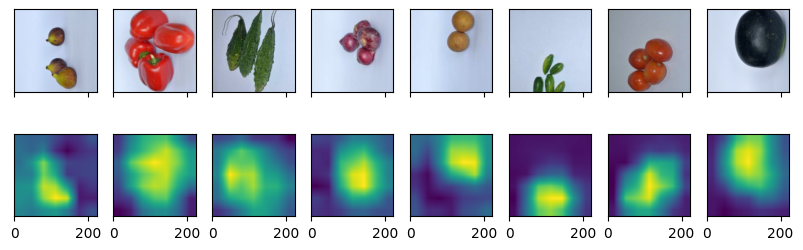

In [144]:
fig, ax = plt.subplots(nrows=2,ncols=len(images),sharey=True,sharex=True,figsize=(10,7))
for i in range(len(images)):
    ax[0,i].imshow(normalize(images[i].transpose(0,2)))
    ax[1,i].imshow(class_activation_maps[i].T)
    ax[0,i].set_yticks([],[])
    ax[1,i].set_yticks([],[])
fig.subplots_adjust(hspace=-0.7)
plt.show()